# Purpose

This notebook is to do analysis on the distribution of listening events across Freebase genres
## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os

## Preparing Data

In [2]:
listeningEvents = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Education Level', 'Age', 'Artist', 'User Id'])
listeningEvents.drop(columns = ['Partition'], inplace = True)
listeningEvents.head(5)

,Education Level,Age,Artist,User Id
0,HS,16,I BREAK HORSES,15397460
1,HS,16,TAYLOR SWIFT,15397460
2,HS,16,HIM,15397460
3,HS,16,AMARANTHE,15397460
4,HS,16,AMARANTHE,15397460


In [3]:
artistToGenre = pd.read_parquet('../data/LastFM1bKidArtistToFreebaseGenre.gzip.parquet')
artistToGenre.head(5)

,Artist,Genre
0,MEGADETH,HEAVY METAL
1,DREAM THEATER,HEAVY METAL
2,AMON AMARTH,HEAVY METAL
3,ALTER BRIDGE,HEAVY METAL
4,LIMP BIZKIT,HEAVY METAL


In [4]:
data = listeningEvents.merge(artistToGenre, on = 'Artist')
data.drop(columns = ['Artist'], inplace = True)
data.head(5)

,Education Level,Age,User Id,Genre
0,HS,16,15397460,ROCK
1,HS,16,15397460,POP
2,HS,16,15397460,ALTERNATIVE
3,HS,16,15397460,INDIE
4,HS,16,15397460,INDIE ROCK


In [5]:
listeningEvents = artistToGenre = None

## Computing Mean Genre Listening Event per User 

In [6]:
data = data.groupby(['Education Level', 'Age', 'User Id', 'Genre'], observed = True).agg(Count = ('Genre', 'count')).reset_index()
data.head(5)

,Education Level,Age,User Id,Genre,Count
0,HS,15,7576766,ROCK,12762
1,HS,15,7576766,POP,11980
2,HS,15,7576766,ALTERNATIVE,17276
3,HS,15,7576766,INDIE,14191
4,HS,15,7576766,INDIE ROCK,11377


In [7]:
temp = data.groupby(['User Id']).agg(Total = ('Count', 'sum')).reset_index()
temp.head(5)

,User Id,Total
0,2014225,322259
1,2484832,340725
2,2635077,2076359
3,2921901,363964
4,3556768,275856


In [8]:
data = data.merge(temp, on = 'User Id')
data.head(5)

,Education Level,Age,User Id,Genre,Count,Total
0,HS,15,7576766,ROCK,12762,430774
1,HS,15,7576766,POP,11980,430774
2,HS,15,7576766,ALTERNATIVE,17276,430774
3,HS,15,7576766,INDIE,14191,430774
4,HS,15,7576766,INDIE ROCK,11377,430774


In [9]:
data['Mean'] = data['Count'] / data['Total']
data.head(5)

,Education Level,Age,User Id,Genre,Count,Total,Mean
0,HS,15,7576766,ROCK,12762,430774,0.029626
1,HS,15,7576766,POP,11980,430774,0.027810
2,HS,15,7576766,ALTERNATIVE,17276,430774,0.040105
3,HS,15,7576766,INDIE,14191,430774,0.032943
4,HS,15,7576766,INDIE ROCK,11377,430774,0.026411


## Computing Mean Genre Listening Event per User per Education Level

In [10]:
graphData = data.groupby(['Education Level', 'Genre'], observed = True).agg(Mean = ('Mean', 'mean'))
graphData = graphData.reset_index()
graphData.head(5)

,Education Level,Genre,Mean
0,HS,ROCK,0.044762
1,HS,POP,0.030783
2,HS,ALTERNATIVE,0.043180
3,HS,INDIE,0.028688
4,HS,INDIE ROCK,0.019231


### Raw Data

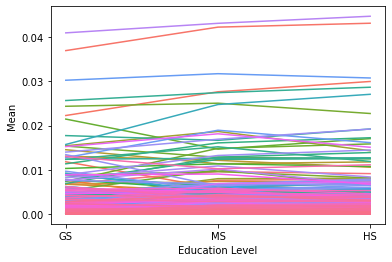

In [11]:
sns.lineplot(data = graphData, x = 'Education Level', hue = 'Genre', y = 'Mean', legend = False);

In [12]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for pair in [('Top 1%', .01), ('Top 2%', .02), ('Top 3%', .03), ('Top 4%', .04), ('Top 5%', .05), ('Top 10%', .10), ('Top 50%', .50), ('All', 1)]:
    cutoff = np.quantile(total['Total'], q = 1 - pair[1])

    top = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(top)].groupby(['Education Level']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': pair[0]})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 'All'][['Education Level', 'Value']], on = 'Education Level')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Education Level,Value_x,Value_y,Value
0,Top 1%,GS,0.304309,1.181541,0.257552
1,Top 2%,GS,0.447504,1.181541,0.378746
2,Top 3%,GS,0.551272,1.181541,0.466570
3,Top 4%,GS,0.614745,1.181541,0.520291
4,Top 5%,GS,0.676322,1.181541,0.572407
5,Top 10%,GS,0.853990,1.181541,0.722777
6,Top 50%,GS,1.147370,1.181541,0.971079
7,All,GS,1.181541,1.181541,1.000000
8,Top 1%,MS,0.342269,1.463112,0.233932
9,Top 2%,MS,0.498435,1.463112,0.340668


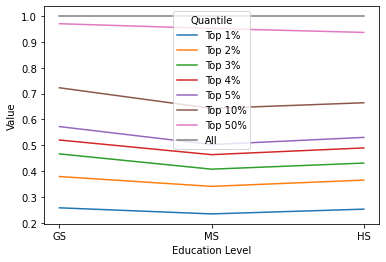

In [13]:
sns.lineplot(data = topData, x = 'Education Level', hue = 'Quantile', y = 'Value');

In [14]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for top in range(1, 101, 1):
    cutoff = np.quantile(total['Total'], q = 1 - (top / 100))

    topGenres = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(topGenres)].groupby(['Education Level']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': top})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 100][['Education Level', 'Value']], on = 'Education Level')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Education Level,Value_x,Value_y,Value
0,1,GS,0.304309,1.181541,0.257552
1,2,GS,0.447504,1.181541,0.378746
2,3,GS,0.551272,1.181541,0.466570
3,4,GS,0.614745,1.181541,0.520291
4,5,GS,0.676322,1.181541,0.572407
...,...,...,...,...,...
295,96,HS,1.368605,1.369102,0.999637
296,97,HS,1.368843,1.369102,0.999811
297,98,HS,1.368971,1.369102,0.999904
298,99,HS,1.369057,1.369102,0.999968


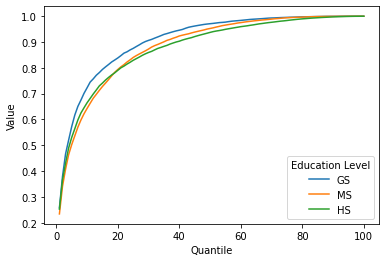

In [15]:
sns.lineplot(data = topData, x = 'Quantile', hue = 'Education Level', y = 'Value');

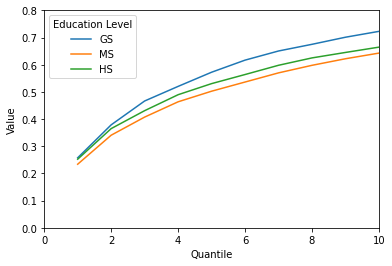

In [16]:
g = sns.lineplot(data = topData, x = 'Quantile', hue = 'Education Level', y = 'Value')
g.set(xlim = (0, 10), ylim = (0, .8));

## Computing Mean Genre Listening Event per User per High School Age

In [17]:
graphData = data.groupby(['Age', 'Genre'], observed = True).agg(Mean = ('Mean', 'mean'))
graphData = graphData.reset_index()
graphData.head(5)

,Age,Genre,Mean
0,6,ROCK,0.041927
1,6,POP,0.030257
2,6,ALTERNATIVE,0.037781
3,6,INDIE,0.023594
4,6,INDIE ROCK,0.015275


### Raw Data

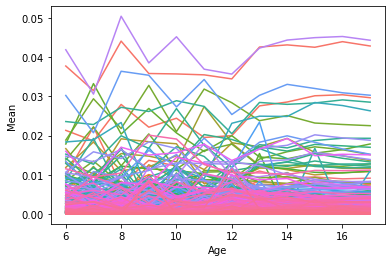

In [18]:
sns.lineplot(data = graphData, x = 'Age', hue = 'Genre', y = 'Mean', legend = False);

### Top % Quantile Genres

In [19]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for pair in [('Top 1%', .01), ('Top 2%', .02), ('Top 3%', .03), ('Top 4%', .04), ('Top 5%', .05), ('Top 10%', .10), ('Top 50%', .50), ('All', 1)]:
    cutoff = np.quantile(total['Total'], q = 1 - pair[1])

    top = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(top)].groupby(['Age']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': pair[0]})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 'All'][['Age', 'Value']], on = 'Age')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Age,Value_x,Value_y,Value
0,Top 1%,6,0.296355,1.114382,0.265937
1,Top 2%,6,0.435748,1.114382,0.391022
2,Top 3%,6,0.538277,1.114382,0.483028
3,Top 4%,6,0.610365,1.114382,0.547716
4,Top 5%,6,0.653444,1.114382,0.586374
...,...,...,...,...,...
91,Top 4%,17,0.654612,1.347030,0.485967
92,Top 5%,17,0.714208,1.347030,0.530209
93,Top 10%,17,0.893948,1.347030,0.663643
94,Top 50%,17,1.257764,1.347030,0.933731


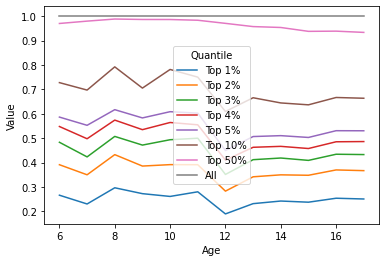

In [20]:
sns.lineplot(data = topData, x = 'Age', hue = 'Quantile', y = 'Value');

In [21]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for top in range(1, 101, 1):
    cutoff = np.quantile(total['Total'], q = 1 - (top / 100))

    topGenres = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(topGenres)].groupby(['Age']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': top})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 100][['Age', 'Value']], on = 'Age')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Age,Value_x,Value_y,Value
0,1,6,0.296355,1.114382,0.265937
1,2,6,0.435748,1.114382,0.391022
2,3,6,0.538277,1.114382,0.483028
3,4,6,0.610365,1.114382,0.547716
4,5,6,0.653444,1.114382,0.586374
...,...,...,...,...,...
1195,96,17,1.346539,1.347030,0.999635
1196,97,17,1.346823,1.347030,0.999846
1197,98,17,1.346904,1.347030,0.999906
1198,99,17,1.346993,1.347030,0.999972


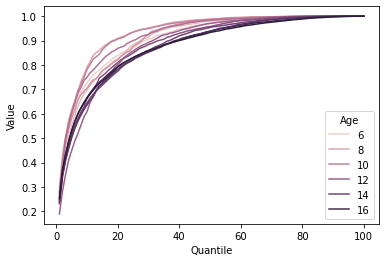

In [22]:
sns.lineplot(data = topData, x = 'Quantile', hue = 'Age', y = 'Value');

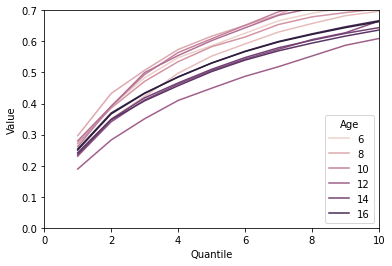

In [23]:
g = sns.lineplot(data = topData, x = 'Quantile', hue = 'Age', y = 'Value')
g.set(xlim = (0, 10), ylim = (0, .7));